## Representation of Board for Network

In [1]:
#from board import *...
#board.toVector()

# Neural Network Stuff
Trying to add pytorch stuff to the old code. 

In [11]:
import torch
import numpy as np
import neuralnetworks as nn
import math
import matplotlib.pyplot as plt
import pandas as pd
import mlutils as ml
import time

In [2]:
## Traditional arrays
X = np.arange(10).reshape((-1,1))
X = X.astype(float)
T = X + 1 + np.random.uniform(-1, 1, ((10,1)))

## torchy tensors (default to gpu)
Xt = torch.from_numpy(X.astype(float)).cuda() #converts to float for the .mean() call.
Tt = torch.from_numpy(T).cuda()

In [3]:
print(X)
print(Xt)

[[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]
 [7.]
 [8.]
 [9.]]
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]], device='cuda:0', dtype=torch.float64)


In [4]:
cpuNet = nn.NeuralNetwork(X.shape[1], 2, T.shape[1])

In [5]:
gpuNet = nn.NeuralNetwork(Xt.shape[1], 2, Tt.shape[1], True)

In [6]:
cpuNet.train(X,T,100)

NeuralNetwork(1, [2], 1)
   Network was trained for 101 iterations. Final error is 0.32780252256851294.

In [7]:
gpuNet.train(Xt,Tt,100)

NeuralNetwork(1, [2], 1)
   Network was trained for 101 iterations. Final error is 0.8597776191837884.

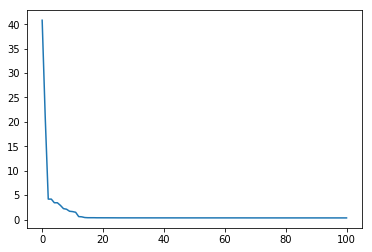

In [8]:
plt.plot(cpuNet.getErrors())

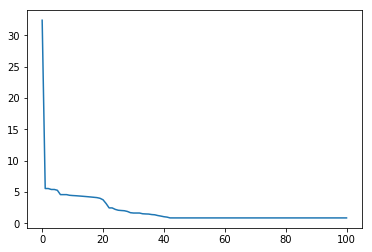

In [9]:
plt.plot(gpuNet.getErrors())

The above code doesn not get really reliable results. Could be something wrong with the scg though...

In [10]:
# testing with a5 data...
csv = pd.read_csv("energydata_complete.csv")
#drop unneeded columns
csv = csv.drop(['date', 'rv1', 'rv2'], axis = 1)
data = csv.values #.values is a numpy array! 
Tenergy = data[:, :2]
Xenergy = data[:, 2:]

In [14]:
testNN = nn.NeuralNetwork(Xenergy.shape[1], [10,10], Tenergy.shape[1])
testNN.train(Xenergy, Tenergy, 10000) #300 should be fine
#Final error is not the same as RMSE


NeuralNetwork(24, [10, 10], 2)
   Network was trained for 10001 iterations. Final error is 4715.99911828145.

In [15]:
XenergyGPU = torch.from_numpy(Xenergy).cuda()
TenergyGPU = torch.from_numpy(Tenergy).cuda()
testNNGPU = nn.NeuralNetwork(XenergyGPU.shape[1], [10,10], TenergyGPU.shape[1], True)
testNNGPU.train(XenergyGPU, TenergyGPU, 10000) #300 should be fine
#Final error is not the same as RMSE

NeuralNetwork(24, [10, 10], 2)
   Network was trained for 10001 iterations. Final error is 10074.343105026634.

In [16]:
def train(X, T, learning_rate_hidden, learning_rate_output, nHiddens, nIterations):
    nSamples = X.shape[0]
    nOutputs = T.shape[1]

    # Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
    V = 0.1*2*(np.random.uniform(size=(1+1, nHiddens))-0.5)
    W = 0.1*2*(np.random.uniform(size=(1+nHiddens ,nOutputs))-0.5)

    if not isinstance(X, np.ndarray):
        V = torch.from_numpy(V).cuda()
        W = torch.from_numpy(W).cuda()

    start_time = time.time()
    
    for step in range(nIterations):

        # Forward pass on training data
        if isinstance(X, np.ndarray):
            Z = np.tanh(X @ V[1:, :] + V[0:1, :])
        else:
            Z = (X @ V[1:, :] + V[0:1, :]).tanh()
        Y = Z @ W[1:, :] + W[0:1, :]

        # Error in output
        deltaW = (T - Y) / nSamples

        lrh = learning_rate_hidden
        lro = learning_rate_output
        # Backward pass - the backpropagation and weight update steps
        try:
            deltaV = (deltaW @ W[1:, :].T) * (1 - Z**2)
            V[1:, :] += lrh * X.T @ deltaV
            V[0:1, :] += lrh * deltaV.sum(0)
            W[1:, :] += lro * Z.T @ deltaW
            W[0:1, :] += lro * deltaW.sum()
        except:
            deltaV = (deltaW @ W[1:, :].t()) * (1 - Z**2)
            V[1:, :] += lrh * X.t() @ deltaV
            V[0:1, :] += lrh * deltaV.sum(0)
            W[1:, :] += lro * Z.t() @ deltaW
            W[0:1, :] += lro * deltaW.sum()
           
    print('train took', time.time() - start_time, 'seconds')
    
    return V, W
def use(X, V, W):
    if isinstance(X, np.ndarray):
        Z = np.tanh(X @ V[1:, :] + V[0:1, :])
    else:
        Z = (X @ V[1:, :] + V[0:1, :]).tanh()
    Y = Z @ W[1:, :] + W[0:1, :]
    return Y

In [21]:
V, W = train(Xenergy, Tenergy, 10, .01, 50, 100)

ValueError: shapes (19735,24) and (1,50) not aligned: 24 (dim 1) != 1 (dim 0)

In [24]:
def train_pytorch(X, T, learning_rate, nHiddens, nIterations, useAdam=False):
    
    class Torchnn(torch.nn.Module):
    
        def __init__(self, n_inputs, n_hidden_units, n_outputs):
            super(Torchnn, self).__init__()
            self.hidden = torch.nn.Linear(n_inputs, n_hidden_units) 
            self.tanh = torch.nn.Tanh()
            self.output = torch.nn.Linear(n_hidden_units, n_outputs)

        def forward(self, X):
            out = self.hidden(X)
            out = self.tanh(out)
            out = self.output(out)
            return out

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Running on', device)
    
    torchnn = Torchnn(1, nHiddens, 1).to(device).double()  # default is single precision
    
    if useAdam:
        optimizer = torch.optim.Adam(torchnn.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(torchnn.parameters(), lr=learning_rate)
    loss_func = torch.nn.MSELoss()
    
    errors = []
    startTime = time.time()

    for iteration in range(nIterations):
        # Forward pass
        outputs = torchnn(X)
        loss = loss_func(outputs, T)
        errors.append(torch.sqrt(loss))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Training took {} seconds'.format(time.time() - startTime))
    
    return torchnn, errors

In [25]:
torchnn, errors = train_pytorch(XenergyGPU, TenergyGPU, .01, 50, 100)

Running on cuda


RuntimeError: size mismatch, m1: [19735 x 24], m2: [1 x 50] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:249

Well this section seems to be dead to me. I cannot get anything to work consistently. We'll have to go with the old nn implementation and waiting instead. My server could work as well. 

## Reinforcement Learning With a Neural Network

Will be a combination of the NNet for Hanoi and tic tac toe.

First learn against a dumb opponent. 

Here is the representation of the board. *Unsure of which side should be player. Currently I think its red? Here represented as ones*

Here we train the red player?

In [3]:
from board import *
from piece import *

In [3]:
b = Board()
dr = b.draught
## add kings to show that they have *3 weight
blackKing = Piece(Color.BLACK, (0,1))
blackKing.king_me()
redKing = Piece(Color.RED, (7,6))
redKing.king_me()
dr[0, 1] = blackKing
dr[7, 6] = redKing
b.draught = dr
print(b)
print("The first of valid moves is seen easily in the board, from 0,5 to 4,1")
moves = b.validMoves()
vector = b.stateMoveVectorForNN(moves[0])
len(vector)
#shows a vector representation of the board for the nerual network.
#see newStateRep in notebook 20(?) for more. 


      0 |  1 |  2 |  3 |  4 |  5 |  6 |  7
 0 | -  | BK | -  | B  | -  | B  | -  | B 
 1 | B  | -  | B  | -  | B  | -  | B  | - 
 2 | -  | B  | -  | B  | -  | B  | -  | B 
 3 | -  | -  | -  | -  | -  | -  | -  | - 
 4 | -  | -  | -  | -  | -  | -  | -  | - 
 5 | R  | -  | R  | -  | R  | -  | R  | - 
 6 | -  | R  | -  | R  | -  | R  | -  | R 
 7 | R  | -  | R  | -  | R  | -  | RK | - 

The first of valid moves is seen easily in the board, from 0,5 to 4,1


68

### Using and Testing that bad boy

Imports for the neaded functions:
*description of each*

In [16]:
import NeuralReinforcement as nr
import numpy as np
import time
import datetime
import dill as pickle # this library is like regular pickle but tastier. Serializes lambdas.
import random
from board import *

Some useful function definitions. Doing iterations is much easier in a notebook

In [17]:
def loadNetwork(filename):
    networkDir = "qnets/"
    filename = networkDir + filename
    with open(filename, 'rb') as network_output_file:
        return pickle.load(network_output_file)

In [18]:
def saveNetwork(filename, Qnet):
    networkDir = "qnets/"
    filename = networkDir + filename
    with open(filename, 'wb') as network_output_file:
        pickle.dump(Qnet, network_output_file)

In [19]:
def trainNN(nBatches, nRepsPerBatch, hiddenLayers, nIterations, epsilonDecayFactor):
    epsilon = 1 #haven't needed to change this
    nReplays = 0 # not used
    # nBatches, nRepsPerBatch, hiddenLayers, nIterations, nReplays, epsilon, epsilonDecayFacto
    start = time.time()
    Qnet = nr.trainQnet(nBatches, nRepsPerBatch, hiddenLayers, 
                                           nIterations, nReplays, epsilon, epsilonDecayFactor)
    end = time.time()
    print("Training took {}!".format(str(datetime.timedelta(seconds = end-start))))
    return Qnet

I have tested this itermitently over a few weeks. I was not getting great results at first, starting with win rates at 55%, and eventually getting my best at 70%. But during one of the presentations in the last week, someone had a huge network structure, so I decided to try that. That plus fewer iterations improved performance more, eventually getting up to an 87% win rate! I also found that very few batches with a lot of reps was more favorable. I haven't quite figured out why yet, but I think it has to do with the number of iterations training the nn (more reps and fewer batches = more iterations). 

Here I will show the the performance of my first structures and some simple structures. Then show the better ones. All of the Qnets will be saved using `dill` and put in a the director `Qnets/` so they can be used without retraining. 

In [22]:
try:
    qnet68 = loadNetwork("68.qnet")
except:
    qnet68 = trainNN(20, 10, [68], 10, .97)
    saveNetwork("68.qnet", qnet68)

Black won: batch=0 rep=0 epsilon=1.000 steps=147 outcome=-1, Black won: batch=0 rep=9 epsilon=1.000 steps=192 outcome=-1, Red won: batch=1 rep=10 epsilon=0.970 steps=79 outcome=1, Red won: batch=1 rep=19 epsilon=0.970 steps=193 outcome=1, Red won: batch=2 rep=20 epsilon=0.941 steps=49 outcome=1, Black won: batch=2 rep=29 epsilon=0.941 steps=135 outcome=-1, Black won: batch=3 rep=30 epsilon=0.913 steps=212 outcome=-1, Black won: batch=3 rep=39 epsilon=0.913 steps=213 outcome=-1, Red won: batch=4 rep=40 epsilon=0.885 steps=139 outcome=1, Red won: batch=4 rep=49 epsilon=0.885 steps=175 outcome=1, Red won: batch=5 rep=50 epsilon=0.859 steps=108 outcome=1, Black won: batch=5 rep=59 epsilon=0.859 steps=123 outcome=-1, Red won: batch=6 rep=60 epsilon=0.833 steps=92 outcome=1, Black won: batch=6 rep=69 epsilon=0.833 steps=150 outcome=-1, Red won: batch=7 rep=70 epsilon=0.808 steps=134 outcome=1, Black won: batch=7 rep=79 epsilon=0.808 steps=115 outcome=-1, Red won: batch=8 rep=80 epsilon=0.784

In [ ]:
res = nr.testQ(qnet68.qnet, 1000, maxSteps = 1500)

In [8]:
try:
    qnet50_50_5020x10 = loadNetwork("50_50_5020x10.qnet")
except:
    qnet50_50_5020x10 = trainNN(20, 10, [50, 50, 50], 10, .97)
    saveNetwork("50_50_5020x10.qnet", qnet50_50_5020x10)

Black won: batch=0 rep=0 epsilon=1.000 steps=174 outcome=-1, Red won: batch=0 rep=9 epsilon=1.000 steps=120 outcome=1, Black won: batch=1 rep=10 epsilon=0.970 steps=184 outcome=-1, Red won: batch=1 rep=19 epsilon=0.970 steps=137 outcome=1, Black won: batch=2 rep=20 epsilon=0.941 steps=127 outcome=-1, Black won: batch=2 rep=29 epsilon=0.941 steps=46 outcome=-1, Red won: batch=3 rep=30 epsilon=0.913 steps=118 outcome=1, Black won: batch=3 rep=39 epsilon=0.913 steps=77 outcome=-1, Black won: batch=4 rep=40 epsilon=0.885 steps=122 outcome=-1, Red won: batch=4 rep=49 epsilon=0.885 steps=196 outcome=1, Red won: batch=5 rep=50 epsilon=0.859 steps=83 outcome=1, Black won: batch=5 rep=59 epsilon=0.859 steps=120 outcome=-1, Red won: batch=6 rep=60 epsilon=0.833 steps=148 outcome=1, Red won: batch=6 rep=69 epsilon=0.833 steps=81 outcome=1, Red won: batch=7 rep=70 epsilon=0.808 steps=152 outcome=1, Black won: batch=7 rep=79 epsilon=0.808 steps=158 outcome=-1, Black won: batch=8 rep=80 epsilon=0.78

In [9]:
res = nr.testQ(qnet50_50_5020x10, 1000, maxSteps = 1500)

Red won 57.40% of games!


In [12]:
try:
    qnet50_50_50 = loadNetwork("50_50_50.qnet")
except:
    qnet50_50_50 = trainNN(2, 100, [50, 50, 50], 10, .97)
    saveNetwork("50_50_50.qnet", qnet50_50_50)

Black won: batch=0 rep=0 epsilon=1.000 steps=108 outcome=-1, Black won: batch=0 rep=10 epsilon=1.000 steps=212 outcome=-1, Red won: batch=0 rep=20 epsilon=1.000 steps=126 outcome=1, Black won: batch=0 rep=30 epsilon=1.000 steps=142 outcome=-1, Red won: batch=0 rep=40 epsilon=1.000 steps=110 outcome=1, Red won: batch=0 rep=50 epsilon=1.000 steps=111 outcome=1, Red won: batch=0 rep=60 epsilon=1.000 steps=150 outcome=1, Red won: batch=0 rep=70 epsilon=1.000 steps=145 outcome=1, Red won: batch=0 rep=80 epsilon=1.000 steps=153 outcome=1, Red won: batch=0 rep=90 epsilon=1.000 steps=118 outcome=1, Black won: batch=0 rep=99 epsilon=1.000 steps=131 outcome=-1, Black won: batch=1 rep=100 epsilon=0.970 steps=243 outcome=-1, Red won: batch=1 rep=110 epsilon=0.970 steps=97 outcome=1, Red won: batch=1 rep=120 epsilon=0.970 steps=114 outcome=1, Black won: batch=1 rep=130 epsilon=0.970 steps=209 outcome=-1, Red won: batch=1 rep=140 epsilon=0.970 steps=174 outcome=1, Red won: batch=1 rep=150 epsilon=0.

In [13]:
res = nr.testQ(qnet50_50_50, 1000, maxSteps = 1500)

Red won 65.80% of games!


In [29]:
try:
    qnet100_100 = loadNetwork("100_100.qnet")
except:
    qnet100_100 = trainNN(2, 100, [100,100], 10, .97)
    saveNetwork("100_100.qnet", qnet100_100)

Black won: batch=0 rep=0 epsilon=1.000 steps=194 outcome=-1, Black won: batch=0 rep=10 epsilon=1.000 steps=288 outcome=-1, Black won: batch=0 rep=20 epsilon=1.000 steps=196 outcome=-1, Black won: batch=0 rep=30 epsilon=1.000 steps=208 outcome=-1, Red won: batch=0 rep=40 epsilon=1.000 steps=186 outcome=1, Red won: batch=0 rep=50 epsilon=1.000 steps=181 outcome=1, Black won: batch=0 rep=60 epsilon=1.000 steps=125 outcome=-1, Black won: batch=0 rep=70 epsilon=1.000 steps=184 outcome=-1, Red won: batch=0 rep=80 epsilon=1.000 steps=95 outcome=1, Black won: batch=0 rep=90 epsilon=1.000 steps=164 outcome=-1, Red won: batch=0 rep=99 epsilon=1.000 steps=166 outcome=1, Red won: batch=1 rep=100 epsilon=0.970 steps=114 outcome=1, Red won: batch=1 rep=110 epsilon=0.970 steps=133 outcome=1, Red won: batch=1 rep=120 epsilon=0.970 steps=103 outcome=1, Red won: batch=1 rep=130 epsilon=0.970 steps=73 outcome=1, Black won: batch=1 rep=140 epsilon=0.970 steps=159 outcome=-1, Black won: batch=1 rep=150 eps

In [30]:
res = nr.testQ(qnet100_100, 1000, maxSteps = 1500)

Red won 82.10% of games!


In [40]:
try:
    qnet1000 = loadNetwork("1000.qnet")
except:
    qnet1000 = trainNN(2, 500, [1000], 10, .97)
    saveNetwork("1000.qnet", qnet1000)

In [42]:
res = nr.testQ(qnet1000, 1000, maxSteps = 1500)

Red won 98.20% of games!


Looks like 5 hours of training was worth it!

In [10]:
import matplotlib.pyplot as plt
def plotOutcomes(outcomes, binRate = 10):
    winRate = []
    box = []
    for i in range(len(outcomes)):
        box.append(outcomes[i])
        if i % binRate == 0:
            winRate.append(np.mean(box))
            box = []
    plt.plot(winRate)

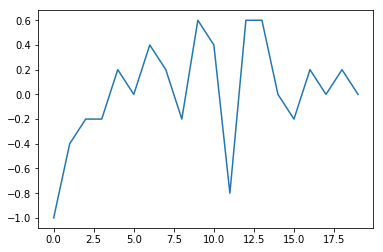

In [11]:
plotOutcomes(qnet50_50_5020x10.outcomes)

Demonstrate what the q value look like here, as well as picking moves.

In [31]:
# create a demonstration board
b = Board()

In [32]:
moves = b.validMoves()

Show all the q values on the best nn. Ought to be pretty sparse but I'm not sure yet. 

In [34]:
for move in moves:
    X = b.stateMoveVectorForNN(move)
    # without this, we give it a list. Needs an np array.
    X = np.array(X)
    # expects a 2d array. We want one row of a that array, so reshape first.
    X = X.reshape(1, 68)
    print(qnet1000.use(X))

[[0.02078446]]
[[0.02232421]]
[[0.0392772]]
[[0.04072942]]
[[0.03672907]]
[[0.03459328]]
[[0.01826239]]


In [36]:
nr.epsilonGreedy(qnet1000, b, 0)

(((5, 4), ((4, 3),)), 0.04072942055390917)

Here we verify that there isn't a bias in checkers that leads red to win. We play random moves against each other to check to see that red wins around 50% of the time. 

In [16]:
def finished(state):
    return len(state.validMoves()) == 0

In [27]:
def randomQ(maxSteps):
    states = []
    done = False
    state = Board()
    step = 0

    while not done and step < maxSteps:
        step += 1

        # Red will make a move
        valid_moves = state.validMoves()
        move = valid_moves[random.randint(0, len(valid_moves) - 1)]
        state.makeMove(move)
        states.append(str(state))

        if finished(state):
            done = True
            return 1
        else:
            # Black will take a turn
            valid_moves = state.validMoves()
            black_move = valid_moves[random.randint(0, len(valid_moves) - 1)]
            state.makeMove(black_move)
            if finished(state):
                done = True
                return 0
    return states


In [36]:
random_wins = []
for _ in range(100):
    random_wins.append(randomQ(1000))

In [37]:
np.mean(random_wins)

0.48

Some preliminary results. I trained with this (30, 100, [50, 50, 50], 20, 0, 1, .99) call and got back a trained neural network! It ran for over an hour and a half, which indicates some tweaking is necessary(reduce the reps, increse the batches? Should lower matrix size for training). I ran useQ for 5000 simulated games against a random opponent, and the Qnet won 55.85% of the time. A random player for red won 50.52% of the time with the same number of games. This seems to suggest that the neural network has at the very least learned something, although I think that the structure could be improved, and it is possible that I messed up the implementation. Although its odd that I would still get somewhat positive results anyways.